In [37]:
import scipy as sp
import numpy as np
import qibo
from qibo.symbols import *
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import unitary_group

from functions import *

In [65]:
def matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI", rootSelection = False, trotterization = 1):

    steps = len(coeffs)
    state = initState.copy()
    coeffs2 = coeffs.copy()
    for i in range(steps):
        energy = np.real(np.vdot(state, H @ state))
        #pick the coefficient such that np.abs(E-coeff) is maximized
        if rootSelection:
            coeff = coeffs2[np.argmax(np.abs(coeffs2 - energy))]
            coeffs2 = np.delete(coeffs2, np.argmax(np.abs(coeffs2 - energy)))
        else:
            coeff = coeffs[i]

        s, theta = matrixPolynomialScheduling(state, H, coeff)
        s /= trotterization 
        sign = np.sign(s)
        s = np.abs(s)
        t = sign*np.sqrt(np.abs(s)/trotterization)
        rho = np.outer(state, state.conj())
        W = commutator(rho, H)

        if method == "DBI":
            state = sp.linalg.expm(1j*theta*rho) @ sp.linalg.expm(sign*s*W) @ state
        elif method == "DBQITE":
            operator  = sp.linalg.expm(1j*sign*t*H) @ sp.linalg.expm(1j*sign*t*rho) @ sp.linalg.expm(-1j*sign*t*H)@sp.linalg.expm(-1j*sign*t*rho)
            for _ in range(trotterization):
                state = operator @ state
            state = sp.linalg.expm(1j*theta*rho)@state
        elif method == "DBQITE3":
            phi = (np.sqrt(5)-1)/2
            phi2 = (np.sqrt(5)+1)/2
            phi3 = (3-np.sqrt(5))/2
            ref1 = sp.linalg.expm(1j*phi*t*rho)
            ref2 = sp.linalg.expm(-1j*phi2*t*rho)
            if sign < 0:
                U = sp.linalg.expm(1j*phi3*t*H) @ ref2 @ sp.linalg.expm(-1j*t*H) @ ref1 @ sp.linalg.expm(1j*phi*t*H)
            else:
                U = sp.linalg.expm(1j*phi*t*H) @ ref1 @ sp.linalg.expm(-1j*t*H) @ ref2 @ sp.linalg.expm(1j*phi3*t*H)
            for _ in range(trotterization):
                state = U @ state
               
            state = sp.linalg.expm(1j*theta*rho) @ state
            
    state = state / np.linalg.norm(state)
    return state, sign*s

In [45]:
def DBQITE_thirdOrder(iters, H, step, state, trotterization = 1):
    """
    DBQITE 3rd order algorithm.
    """
    phi = (np.sqrt(5)-1)/2
    phi2 = (np.sqrt(5)+1)/2
    phi3 = (3-np.sqrt(5))/2
    newState = np.empty((iters+1,len(state)), dtype=complex)
    newState[0,:] = state
    sign = np.sign(step)
    step = np.abs(step)
    t = sign*np.sqrt(step)
    
    step = step / trotterization
    for i in range(iters):
        # rho = np.outer(newState[i,:], newState[i,:].conj())
        # ref1 = sp.linalg.expm(1j*phi*sign*np.sqrt(step)*rho)
        # ref2 = sp.linalg.expm(-1j*(phi+1)*sign*np.sqrt(step)*rho)
        # U = sp.linalg.expm(1j*phi*sign*np.sqrt(step)*H) @ ref1 @ sp.linalg.expm(-1j*sign*np.sqrt(step)*H) @ ref2 @ sp.linalg.expm(1j*(1-phi)*sign*np.sqrt(step)*H)
        rho = np.outer(state, state.conj())

        phi = (np.sqrt(5)-1)/2
        phi2 = (np.sqrt(5)+1)/2
        phi3 = (3-np.sqrt(5))/2
        ref1 = sp.linalg.expm(1j*phi*t*rho)
        ref2 = sp.linalg.expm(-1j*phi2*t*rho)
        if sign < 0:
            U = sp.linalg.expm(1j*phi3*t*H) @ ref2 @ sp.linalg.expm(-1j*t*H) @ ref1 @ sp.linalg.expm(1j*phi*t*H)
        else:
            U = sp.linalg.expm(1j*phi*t*H) @ ref1 @ sp.linalg.expm(-1j*t*H) @ ref2 @ sp.linalg.expm(1j*phi3*t*H)
        state = U @ state
        for _ in range(trotterization):
            newState[i+1,:] = U@newState[i,:]
            newState[i+1,:] = newState[i+1,:]/np.sqrt(np.conj(newState[i+1,:])@newState[i+1,:])
    return newState

[Qibo 0.2.16|WARNING|2025-06-05 18:44:06]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 200/200 [00:00<00:00, 455.17it/s]


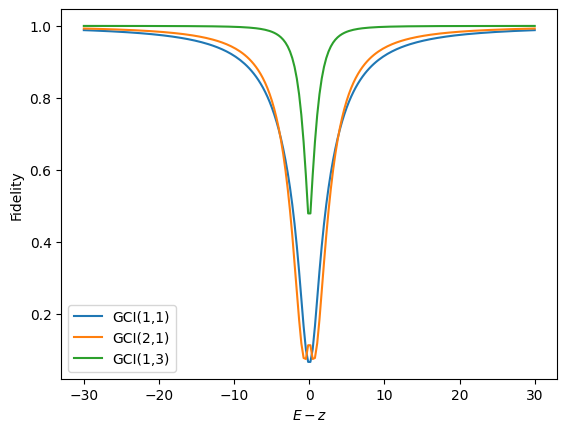

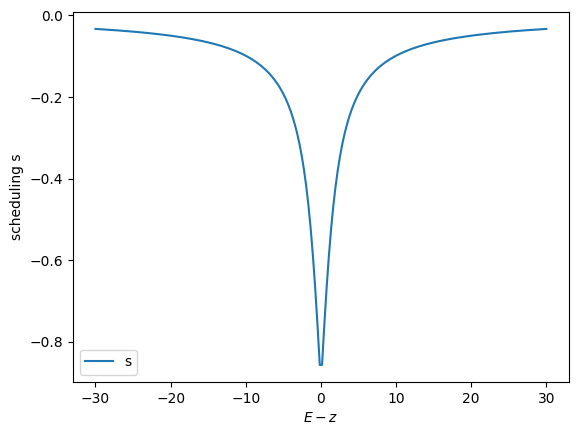

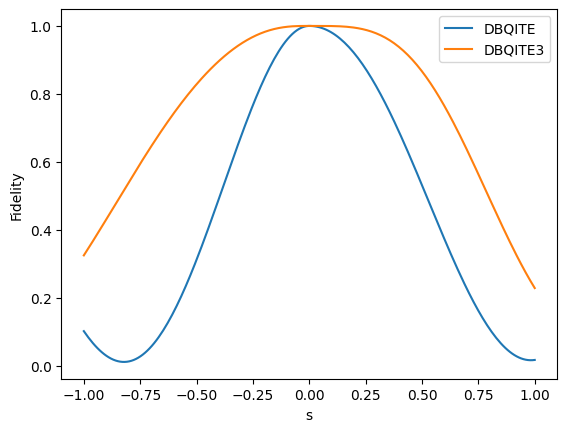

In [66]:
nqubits = 4
H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix


initState = np.zeros(2**nqubits, dtype=complex)
initState[0] = 1.0

E = energy(H, initState)

root = np.linspace(E-30, E+30, 200)
fidelity = np.zeros(len(root))
fidelityQITE = np.zeros(len(root))
fidelityQITE2 = np.zeros(len(root))
fidelityQITE3 = np.zeros(len(root))
s = np.zeros(len(root), dtype=complex)

for z in tqdm(range(len(root))):
    operator = H - root[z] * np.eye(2**nqubits)
    exactState = operator @ initState
    exactState = exactState / np.linalg.norm(exactState)

    dbiState, s[z] = matrixPolynomialEvolutionDBI(initState, H, [root[z]], method = "DBI")
    dbqiteState, _ = matrixPolynomialEvolutionDBI(initState, H, [root[z]], method = "DBQITE")
    dbqiteState2, _ = matrixPolynomialEvolutionDBI(initState, H, [root[z]], method = "DBQITE", trotterization=2)

    dbqite3State, _ = matrixPolynomialEvolutionDBI(initState, H, [root[z]], method = "DBQITE3", trotterization=1)
    fidelityQITE[z] = np.abs(np.vdot(dbiState, dbqiteState))**2
    fidelityQITE2[z] = np.abs(np.vdot(dbiState, dbqiteState2))**2
    fidelityQITE3[z] = np.abs(np.vdot(dbiState, dbqite3State))**2
    fidelity[z] = np.abs(np.vdot(exactState, dbiState))**2

steps = np.linspace(-1,1, 200)
fidelity1 = np.zeros(len(steps))
fidelity2 = np.zeros(len(steps))
fidelity3 = np.zeros(len(steps))
for i in range(len(steps)):
    dbiState = DBI(1, H, steps[i], initState)[-1,:]
    dbqiteState = DBQITE(1, H, steps[i], initState, trotterization=5)[1,:]
    dbqite3State = DBQITE_thirdOrder(1, H, steps[i], initState)[-1,:]
    fidelity1[i] = np.abs(np.vdot(dbiState, dbqiteState))**2
    fidelity2[i] = np.abs(np.vdot(dbiState, dbqite3State))**2

plt.figure()
plt.plot(E-root, fidelityQITE, label="GCI(1,1)")
plt.plot(E-root, fidelityQITE2, label="GCI(2,1)")
plt.plot(E-root, fidelityQITE3, label="GCI(1,3)")

plt.xlabel(r"$E-z$")
plt.ylabel("Fidelity")
plt.legend()

plt.figure()
plt.plot(E-root, s, label="s")
plt.xlabel(r"$E-z$")
plt.ylabel("scheduling s")
plt.legend()

plt.figure()
plt.plot(steps, fidelity1, label="DBQITE")
plt.plot(steps, fidelity2, label="DBQITE3")
plt.xlabel("s")
plt.ylabel("Fidelity")
plt.legend()
plt.show()


In [19]:
dbqite3State, s1 = matrixPolynomialEvolutionDBI(initState, H, [E-1], method = "DBQITE3")
dbqite3State2, s2 = matrixPolynomialEvolutionDBI(initState, H, [E+1], method = "DBQITE")
print(s1-s2)
print(Fidelity(dbqite3State, dbqite3State2))

0.0
0.8144616160099398


Text(0, 0.5, 'Fidelity with H$| \\psi \\rangle$')

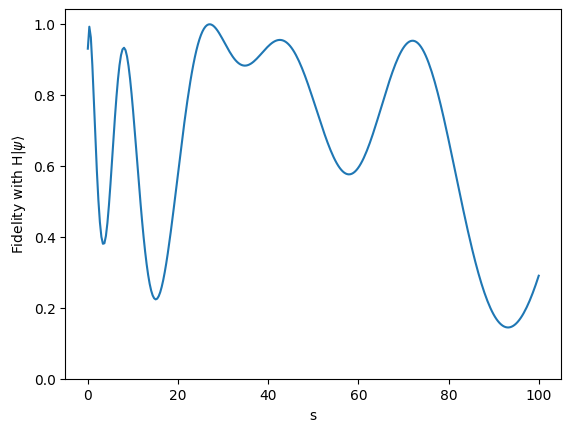

In [4]:
nqubits = 1

H = np.random.normal(0, 1, (2**nqubits, 2**nqubits)) + 1j * np.random.normal(0, 1, (2**nqubits, 2**nqubits))
H = H + H.conj().T
#H = H / np.linalg.norm(H)

I = np.eye(2**nqubits)

initState = np.random.random(2**nqubits) + 1j * np.random.random(2**nqubits)
initState = initState / np.linalg.norm(initState)

targetState = H @ initState
targetState = targetState / np.linalg.norm(targetState)

s = np.linspace(0, 100, 300)
fidelity = np.zeros((len(s)))

for step in range(len(s)):
    state = DBQITE(1, H, s[step], initState) [-1,:]
    fidelity[step] = np.abs(np.vdot(state, targetState))**2


plt.figure()
plt.plot(s, fidelity, label="DBQITE")
plt.xlabel("s")
plt.ylim(0)
plt.ylabel(r"Fidelity with H$| \psi \rangle$")


Text(0.5, 1.0, 'Roots of the polynomial')

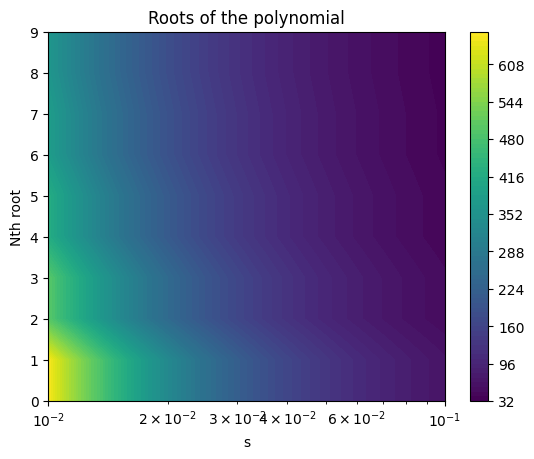

In [42]:
s = np.logspace(-2, -1, 100)
roots = np.zeros((10, len(s)), dtype=complex)
for j in range(len(s)):
        coeffs = findRoots(10, -s[j])
        roots[:,j] = coeffs
plt.figure()
plt.contourf(s, np.arange(10), np.abs(roots), levels=100)
plt.colorbar()
plt.xscale("log")
plt.xlabel("s")
plt.ylabel("Nth root")
plt.title("Roots of the polynomial")

[Qibo 0.2.16|WARNING|2025-04-11 13:46:00]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


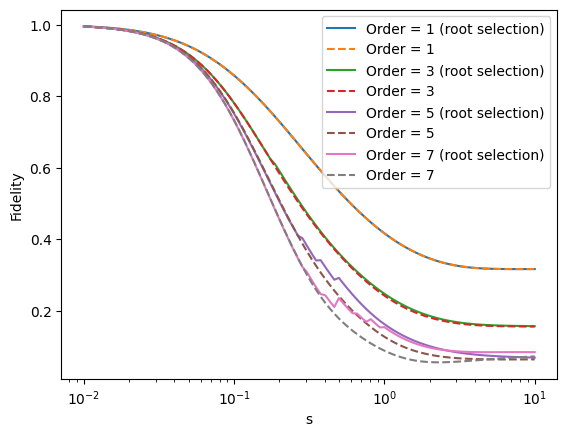

In [198]:
nqubits = 6

H_def = sum([-X(x)+Z(x+1)*Z(x)   for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
initState = np.random.rand(2**nqubits)
initState = initState / np.linalg.norm(initState)



s = np.logspace(-2, 1, 100)
order = [1, 3, 5, 7]
plt.figure()
for i in range(len(order)):
    fidelityDBI = np.zeros(len(s))
    fidelityDBQITE = np.zeros(len(s))
    fidelityDBQITE2 = np.zeros(len(s))
    for j in range(len(s)):
        state = sp.linalg.expm(-s[j]*H) @ initState
        state /= np.linalg.norm(state)
        coeffs = findRoots(order[i], -s[j])
        stateDBI = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI")
        fidelityDBI[j] = Fidelity(stateDBI, state)
        stateDBQITE = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBQITE")
        fidelityDBQITE[j] = Fidelity(stateDBQITE, state)
        stateDBQITE2 = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBQITE", rootSelection = True)
        fidelityDBQITE2[j] = Fidelity(stateDBQITE2, state)

    plt.plot(s, fidelityDBQITE2, label=f"Order = {order[i]} (root selection)")
    plt.plot(s, fidelityDBQITE, '--', label=f"Order = {order[i]} ")
plt.xlabel("s")
plt.xscale("log")
plt.ylabel("Fidelity")
plt.legend()



In [90]:
def inverseTaylorSeriesCoefficients(mu, order):
    coeffs = np.zeros(order+1)
    coeffs[0] = -1/mu
    for i in range(1, order+1):
        coeffs[i] = -1 / (mu**(i+1))
    return coeffs

0.009999999999999972
0.1311111111111103
0.2522222222222236
0.37333333333333063
0.4944444444444493
0.6155555555555545
0.7366666666666659
0.8577777777777782
0.9788888888888889
1.1000000000000003
1.2211111111111117
1.3422222222222222
1.4633333333333345
1.5844444444444463
1.7055555555555568
1.8266666666666675
1.9477777777777794
2.068888888888889
2.189999999999997
2.3111111111111113
2.4322222222222223
2.5533333333333332
2.674444444444445
2.7955555555555573
2.916666666666665
3.037777777777774
3.1588888888888897
3.28
3.4011111111111068
3.5222222222222253
3.6433333333333358
3.7644444444444423
3.8855555555555554
4.006666666666668
4.127777777777777
4.248888888888889
4.369999999999999
4.491111111111114
4.612222222222225
4.733333333333335
4.8544444444444395
4.975555555555556
5.096666666666666
5.217777777777778
5.338888888888889
5.460000000000002
5.581111111111113
5.702222222222225
5.823333333333332
5.9444444444444375
6.065555555555553
6.186666666666666
6.307777777777777
6.428888888888889
6.5500000

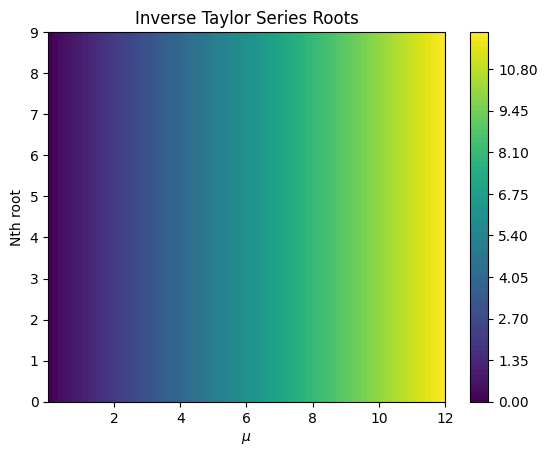

In [91]:
order = 10
mu = np.linspace(0.01, 12, 100)
roots = np.zeros((len(mu), order), dtype=complex)
for i in range(len(mu)):
    coeffs = inverseTaylorSeriesCoefficients(mu[i], order)
    roots[i,:] = np.roots(coeffs[::-1])
    print(np.abs(roots[i,-1]))

plt.figure()
plt.contourf(mu, np.arange(order), np.abs(roots).T, levels=100)
plt.colorbar()
plt.xlabel(r"$\mu$")
plt.ylabel("Nth root")
plt.title("Inverse Taylor Series Roots")
plt.show()

In [92]:
def sgnPolyCoefficients(order):
    max_degree = 2 * order + 1
    coefficients = np.zeros(max_degree + 1)  # Index = degree
    
    for i in range(order + 1):
        # Compute the coefficient for this term
        coeff = (-1)**i / (2*i + 1)
        
        # Get Chebyshev polynomial of degree 2i+1
        c = np.zeros(2*i + 2)
        c[2*i + 1] = 1  # This represents T_{2i+1}(x)
        cheb_poly = np.polynomial.chebyshev .Chebyshev(c)
        
        # Convert to standard polynomial basis
        poly = cheb_poly.convert(kind=np.polynomial.Polynomial)
        
        # Get coefficients in ascending order (x^0, x^1, ..., x^n)
        mono_coeffs = poly.coef
        
        # Pad to match our coefficient array length
        padded = np.zeros_like(coefficients)
        padded[:len(mono_coeffs)] = mono_coeffs
        
        # Accumulate the contribution
        coefficients -= (2/np.pi) * coeff * padded

    coefficients[0] += 0.5
    return coefficients

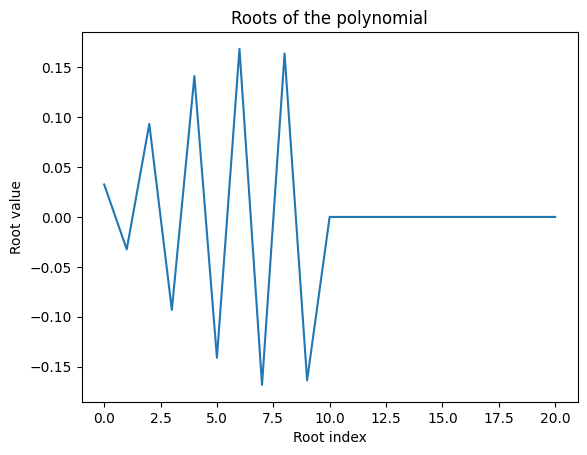

In [188]:
coeffs = sgnPolyCoefficients(10)
roots = np.roots(coeffs[::-1])
plt.figure()
plt.plot(np.imag(roots))
plt.title("Roots of the polynomial")
plt.xlabel("Root index")
plt.ylabel("Root value")
plt.show()

In [ ]:
def powerMethod(E, H, state, nsteps):
    I = np.eye(len(state))
    A = E*I

    for _ in range(nsteps):
        state = (A-H) @ state
        state /= np.linalg.norm(state)
    return state

# def inverseIteration(H, state, shift, nsteps):
    
#     I = np.eye(H.shape[0])
#     for _ in range(nsteps):
#         state = H - shift*I@ state 
#         state /= np.linalg.norm(state)
#     return state

(-0.9894337325055429+8.881784197001252e-16j)


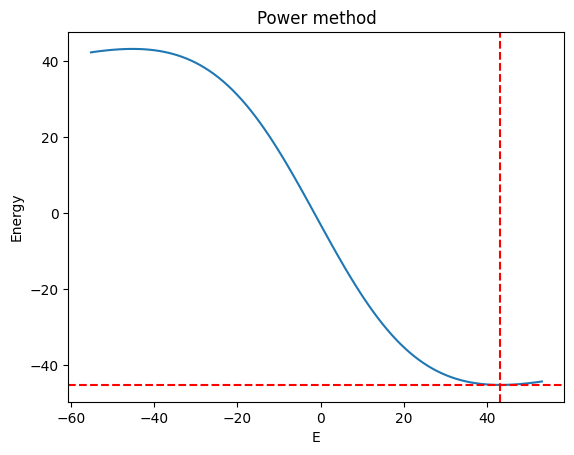

In [404]:
nqubits = 7
H = np.random.normal(0, 1, (2**nqubits, 2**nqubits)) + 1j * np.random.normal(0, 1, (2**nqubits, 2**nqubits))
H = H + H.conj().T
eigenvalues, eigenvectors   = np.linalg.eigh(H)

E0 = np.min(eigenvalues)
E_max = np.max(eigenvalues)
initState = np.zeros (2**nqubits, dtype=complex)
# for i in range(2**nqubits):
#     initState += eigenvectors[:,i]*np.random.random()
initState = 0.5*eigenvectors[:,0] + 0.5*eigenvectors[:,-1]
initState = initState / np.linalg.norm(initState)
print(initState.conj().T @ H @ initState)

E = np.linspace(E0-10, E_max+10, 100)
energy = np.zeros(len(E))
for i in range(len(E)):
    state = powerMethod(E[i],H, initState , 1)
    energy[i] = np.real(np.vdot(state, H @ state))


plt.figure()
plt.plot(E, energy)
plt.axhline(E0, color='r', linestyle='--', label="Ground state energy")
plt.axvline(E_max, color='r', linestyle='--')
plt.xlabel("E")
plt.ylabel("Energy")
plt.title("Power method")
plt.show()